In [1]:
from xgboost import XGBClassifier
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load the training dataset
df = pd.read_csv('Data/train.csv', index_col='PassengerId')

print(df)

# overview of the data
df.describe()

             Survived  Pclass   
PassengerId                     
1                   0       3  \
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age   
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0  \
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...       

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# View the amount of null entries in the dataset
print(df.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


The 'Cabin' column has $ \frac{687}{891} \approx 77\% $ null data so I'll discard this column

In [4]:
drop_cols = ['Cabin']

I'll try to extract some information out of the 'Name' column before dropping it

In [5]:
def generate_titles(df):
    names = df['Name']
    splits = [name.split() for name in names]

    titles = []
    for split in splits:
        for word in split:
            if word.endswith('.'):  # titles end with a . in the dataset
                titles.append(word)
                # to make sure we capture only the title
                break

    titles = pd.Series(titles, index=range(df.index[0], df.index[-1] + 1, 1))

    titles_values = titles.value_counts()
    # dump rare titles together
    titles = titles.apply(lambda x: 'rare' if titles_values[x] < 5 else x)

    return df, titles

In [6]:
def encode_titles(df, titles):
    df['Title'] = titles    
    encoded = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, encoded], axis=1)
    
    # drop the old column and rare titles
    drop_titles = ['Title']
    df.drop(columns=['Title_rare', 'Title', 'Name'], axis=1, inplace=True)
    
    return df

In [7]:
df, train_titles = generate_titles(df)
df = encode_titles(df, train_titles)

Analyse the 'Ticket' column

In [8]:
print(len(df['Ticket'].value_counts()))

681


There doesn't seem to be any info to be substracted from the 'Ticket' column and it's too long to be one-hot encoded. I'll drop it

In [9]:
drop_cols.append('Ticket')

In [10]:
def encode_sex(df):
    df['Sex'] = pd.get_dummies(df['Sex'], drop_first=True)
    return df

def encode_emb(df):
    emb = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, emb], axis=1)
    return df

In [11]:
df = encode_sex(df)
df = encode_emb(df)

drop_cols.append('Embarked')

In [12]:
print(df.head())

             Survived  Pclass    Sex   Age  SibSp  Parch            Ticket   
PassengerId                                                                  
1                   0       3   True  22.0      1      0         A/5 21171  \
2                   1       1  False  38.0      1      0          PC 17599   
3                   1       3  False  26.0      0      0  STON/O2. 3101282   
4                   1       1  False  35.0      1      0            113803   
5                   0       3   True  35.0      0      0            373450   

                Fare Cabin Embarked  Title_Dr.  Title_Master.  Title_Miss.   
PassengerId                                                                  
1             7.2500   NaN        S      False          False        False  \
2            71.2833   C85        C      False          False        False   
3             7.9250   NaN        S      False          False         True   
4            53.1000  C123        S      False          False  

The 'Age' column is cruical for predictions. To decide the way in which to fill the null values see the distribution:

<Axes: ylabel='Age'>

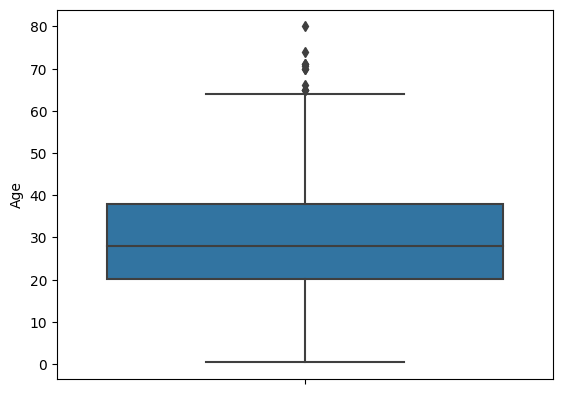

In [13]:
sns.boxplot(y='Age', data=df)

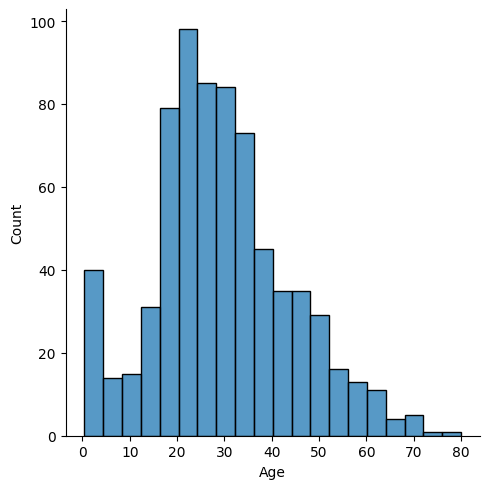

In [14]:
sns.displot(df.Age)

On one hand, there are outliers in the data as seen on the boxplot, so the mean may be skewed towards the higher end, on the other hand there aren't many of them, so the choice between the mean and the median isn't as obvious.
Also certain values are more frequent than others so mode isn't out of the question.  
I'll test each option to see which one fits best

Time to make the cross validation and the train sets

In [15]:
# separate the 'Survived' column
Y_train = df.pop('Survived')

Drop the necessary columns

In [16]:
df.drop(columns=drop_cols, axis=1, inplace=True)

In [17]:
df_mode = df
mode = df['Age'].mode()
df_mode['Age'] = df_mode['Age'].fillna(df_mode['Age'].mode())

df_median = df
df_median['Age'] = df_median['Age'].fillna(df_median['Age'].median())

df['Age'] = df['Age'].fillna(df_mode['Age'].mean())
df_mean = df

In [18]:
X_train_mode = df_mode
X_train_median = df_median
X_train_mean = df_mean

In [19]:
print(X_train_mode)

             Pclass    Sex   Age  SibSp  Parch     Fare  Title_Dr.   
PassengerId                                                          
1                 3   True  22.0      1      0   7.2500      False  \
2                 1  False  38.0      1      0  71.2833      False   
3                 3  False  26.0      0      0   7.9250      False   
4                 1  False  35.0      1      0  53.1000      False   
5                 3   True  35.0      0      0   8.0500      False   
...             ...    ...   ...    ...    ...      ...        ...   
887               2   True  27.0      0      0  13.0000      False   
888               1  False  19.0      0      0  30.0000      False   
889               3  False  28.0      1      2  23.4500      False   
890               1   True  26.0      0      0  30.0000      False   
891               3   True  32.0      0      0   7.7500      False   

             Title_Master.  Title_Miss.  Title_Mr.  Title_Mrs.  Title_Rev.   
PassengerId

In [20]:
# Model training using mode
model_mode = XGBClassifier()

model_mode.fit(np.array(X_train_mode), np.array(Y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
# Model training using median
model_median = XGBClassifier()

model_median.fit(np.array(X_train_mode), np.array(Y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
# Model training using mean
model_mean = XGBClassifier()

model_mean.fit(np.array(X_train_mode), np.array(Y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
X_test = pd.read_csv('Data/test.csv', index_col='PassengerId')

X_test = encode_sex(X_test)
X_test = encode_emb(X_test)
X_test.drop(columns=drop_cols, axis=1, inplace=True)
X_test['Age'].fillna(mode)

X_test, test_titles = generate_titles(X_test)
for title in test_titles:
    if title not in train_titles:
        title = 'rare'

X_test = encode_titles(X_test, test_titles)
missing_columns = set(df.columns) - set(X_test.columns)

for col in missing_columns:
    X_test[col] = False



In [24]:
Y_test_mode = model_mode.predict(X_test)
Y_test_median = model_median.predict(X_test)
Y_test_mean = model_mean.predict(X_test)

Now let's see how the model did by making submissions:

In [25]:
sub = pd.read_csv('Data/gender_submission.csv', index_col='PassengerId')

sub['Survived'] = Y_test_mean
sub.to_csv('gender_submission_mean.csv')

sub['Survived'] = Y_test_median
sub.to_csv('gender_submission_median.csv')

sub['Survived'] = Y_test_mode
sub.to_csv('gender_submission_mode.csv')

### Accuracy on test set with mean sub: 0.64354
### Accuracy on test set with median sub: 0.64354
### Accuracy on test set with mode sub: 0.64354